In [13]:
from model.utils import Logger as LOG
LOG.measure_perf = True # ! ENABLE PERFORMANCE MONITORING
from model.utils import monitor_perf

from model.sign_to_text import SignToText
from model.speech_to_text import SpeechToText
from deep_translator import GoogleTranslator

from media_processing.video import webm_bytes_to_tensor, tensor_to_webm_bytes, load_mp4video_from_file, VideoPipeline
from media_processing.video import write_webm_bytes_to_file, read_webm_bytes_from_file
from media_processing.audio import webm_to_waveform

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame as df

import uuid

red = '\033[91m'
ylw = '\033[93m'
grn = '\033[92m'
blk = '\033[0m'

color_map = [
    "#46bdc6",
    "#4285F4",
    "#ff6d01",
    # "#F4B400",
    "#0F9D58",
]

google_languages = {
            "US": "en",
            "UK": "en",
            "DE": "de",
            "DK": "da"}

In [3]:
train = [
    f'./experiment-data/experiment_vids/train{i}.mp4'
    for i in range(100)
]
load_video = lambda video_idx: load_mp4video_from_file(video_idx)

# Downsampling visualizations

In [5]:
def show_frame(video_array,idx=0):
    plt.imshow(video_array[idx].detach().numpy())
    
def show_seq(video_array, idx_offset):
    w = 35
    h = 35
    fig = plt.figure(figsize=(w, h))
    columns = 10
    rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        show_frame(video_array, idx=i + idx_offset)
    plt.show()

# Performance tests [Sign2Text]

In [7]:
slt_model = SignToText()

Loading state dicts individually
Training backbone from scratch
Training head network from scratch
Freezing up to block 4 in S3D backbone
Loading model from pretrained checkpoint!


In [15]:
pipe = VideoPipeline(W_in=260, H_in=210, WH_out=224, k_t=1.)

In [10]:
# ! when not performing benchmarks
# del slt_model

In [6]:
""" Takes in a list of videos and monitors performance on the full SLT pipeline """
def test_suite_slt(videos, repetitions=1, pipe=None, slt_model=None):
    assert pipe is not None and slt_model is not None, "Missing VideoPipeline and Sign2Text model."
    test_suite_ID = uuid.uuid4()
    for rep in range(repetitions):
        print(f"{red}Test Suite [{test_suite_ID}] {ylw}@ {grn}ITER {rep+1}{blk}")
        for video_idx in videos:
            repetition_ID = uuid.uuid4()
            _video = load_video(video_idx)
            # ? get webm bytes, just like we receive via websocket
            data = tensor_to_webm_bytes(_video)

            # video = webm_bytes_to_tensor(data)
            video = monitor_perf(webm_bytes_to_tensor, 
                                 data, width = 224, height = 224, 
                                 test_suite_ID=test_suite_ID, 
                                 repetition_ID=repetition_ID, 
                                 _input=len(data))

            # video, num_frames = pipe(video, to_file=False, output_length=True)
            video, num_frames = monitor_perf(pipe.__call__, 
                                             video, to_file=False, output_length=True, 
                                             variation=f"VideoPipeline, k_t={pipe.k_t}", 
                                             _input=video.shape[0], 
                                             test_suite_ID=test_suite_ID, 
                                             repetition_ID=repetition_ID)

            # y = slt_model(video, num_frames)[0]
            y = monitor_perf(slt_model.inference, video, num_frames, 
                             variation="Sign2Text", 
                             _input=int(num_frames[0]), 
                             test_suite_ID=test_suite_ID, 
                             repetition_ID=repetition_ID)[0]

            lang_from, lang_to = "DE", "US"
            # y = GoogleTranslator(source=google_languages[lang_from], target=google_languages[lang_to]).translate(y)
            monitor_perf(GoogleTranslator(source=google_languages[lang_from], target=google_languages[lang_to]).translate, y, 
                         variation="Google Translate", 
                         test_suite_ID=test_suite_ID, 
                         repetition_ID=repetition_ID)
        LOG.perfmon_step()
    print(f"{red}Test Suite [{test_suite_ID}] {ylw}@ {grn}FINISHED{blk}")


In [21]:
""" Reset metrics (stores backup) """
LOG.reset_perf_metrics()

""" Run performance tests for 3 values of k_t """
pipe.k_t = 1.
test_suite_slt(train, repetitions=1, slt_model=slt_model, pipe=pipe)
pipe.k_t = .5
test_suite_slt(train, repetitions=1, slt_model=slt_model, pipe=pipe)
pipe.k_t = .33333
test_suite_slt(train, repetitions=1, slt_model=slt_model, pipe=pipe)

""" Save .csv-file """
LOG.save_perf_metrics()

Test Suite [a5750da8-a544-43ca-820a-83dc88ab30aa] @ ITER 1
[1] Perf @ STARTING :: webm_bytes_to_tensor
[1] Perf @ FINISHED [time: 0.058727026 s] [perf_counter: 0.058727833 s] [process_time: 0.014976000 s] :: webm_bytes_to_tensor
[2] Perf @ STARTING :: __call__
[2] Perf @ FINISHED [time: 0.024096012 s] [perf_counter: 0.024095916 s] [process_time: 0.115164000 s] :: __call__
[3] Perf @ STARTING :: inference


/Users/nielsraunkjaer/Desktop/Bachelor/SltServer/media_processing/video.py:69: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:1468.)
  video_tensor = torch.frombuffer(stdout, dtype=torch.uint8)


[3] Perf @ FINISHED [time: 2.610334158 s] [perf_counter: 2.610339375 s] [process_time: 6.839669000 s] :: inference
[4] Perf @ STARTING :: translate
[4] Perf @ FINISHED [time: 0.156471014 s] [perf_counter: 0.156471292 s] [process_time: 0.020538000 s] :: translate
[5] Perf @ STARTING :: webm_bytes_to_tensor
[5] Perf @ FINISHED [time: 0.069799900 s] [perf_counter: 0.069800708 s] [process_time: 0.020081000 s] :: webm_bytes_to_tensor
[6] Perf @ STARTING :: __call__
[6] Perf @ FINISHED [time: 0.035912037 s] [perf_counter: 0.035912333 s] [process_time: 0.172360000 s] :: __call__
[7] Perf @ STARTING :: inference
[7] Perf @ FINISHED [time: 3.290123224 s] [perf_counter: 3.290130292 s] [process_time: 8.948875000 s] :: inference
[8] Perf @ STARTING :: translate
[8] Perf @ FINISHED [time: 0.154500961 s] [perf_counter: 0.154502000 s] [process_time: 0.011020000 s] :: translate
[9] Perf @ STARTING :: webm_bytes_to_tensor
[9] Perf @ FINISHED [time: 0.061197042 s] [perf_counter: 0.061198416 s] [process_

In [ ]:
""" see dataframe as table """
LOG.perf_metrics

In [ ]:
""" manually save dataframe """
LOG.save_perf_metrics()

In [ ]:
""" reset dataframe - will save current contents to backups folder """ 
LOG.reset_perf_metrics()

# Visualization [Sign2Text]

In [25]:
# get the model out of memory :D
del slt_model

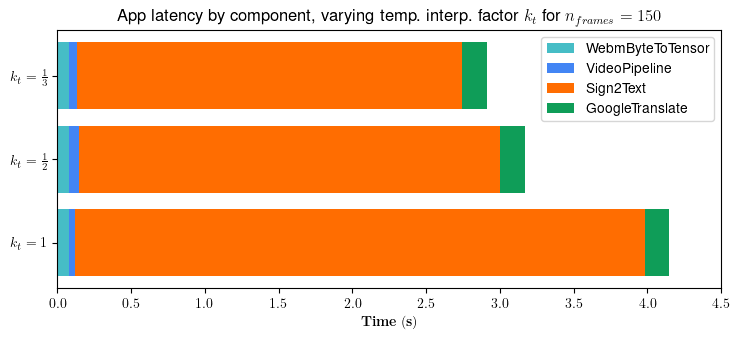

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

kt = ["$k_t = 1$", "$k_t = \\frac{1}{2}$", "$k_t = \\frac{1}{3}$"]

# ! Values computed in spreadsheet found @ [https://tinyurl.com/PerformanceData]
s2t_pipeline_times =  np.array([[7.67e-02, 7.67e-02, 7.67e-02], # byte_to_tensor
                                [4.10e-02, 6.63e-02, 5.35e-02], # video_pipe
                                np.array([0.792, 1.03, 1.11])+            # s2t_overhead
                                np.array([3.075, 1.83, 1.505]),           # s2t_variable (*150)
                                [1.65e-01, 1.65e-01, 1.65e-01], # google_translate
                                ]).T

# hacky one-liner because of weird matplotlib hbar syntax
plots = [plt.barh(kt, s2t_pipeline_times[:,0], color=color_map[0])] + \
    [plt.barh(kt, s2t_pipeline_times[:,i], left=np.sum(s2t_pipeline_times[:,:i], axis=1), color=color_map[i]) for i in range(1,len(color_map))]

components = ["WebmByteToTensor", 
            "VideoPipeline", 
            "Sign2Text", 
            "GoogleTranslate"]
plt.legend(plots, 
           components,
            loc="upper right")

plt.xticks([x/2 for x in range(9+1)])
plt.xlabel("$\mathbf{Time~(s)}$")
# plt.grid(axis="x")

plt.title("App latency by component, varying temp. interp. factor $k_t$ for $n_{frames}=150$")
# plt.show()
plt.savefig("waterfall_diagram_v3.png")

In [4]:
s2t_pipeline_times, np.sum(s2t_pipeline_times,axis=1), np.array([s2t_pipeline_times[i,:] / x for i,x in enumerate(np.sum(s2t_pipeline_times,axis=1))])

(array([[0.0767, 0.041 , 3.867 , 0.165 ],
        [0.0767, 0.0663, 2.86  , 0.165 ],
        [0.0767, 0.0535, 2.615 , 0.165 ]]),
 array([4.1497, 3.168 , 2.9102]),
 array([[0.01848326, 0.00988023, 0.93187459, 0.03976191],
        [0.02421086, 0.02092803, 0.90277778, 0.05208333],
        [0.02635558, 0.01838362, 0.89856367, 0.05669713]]))

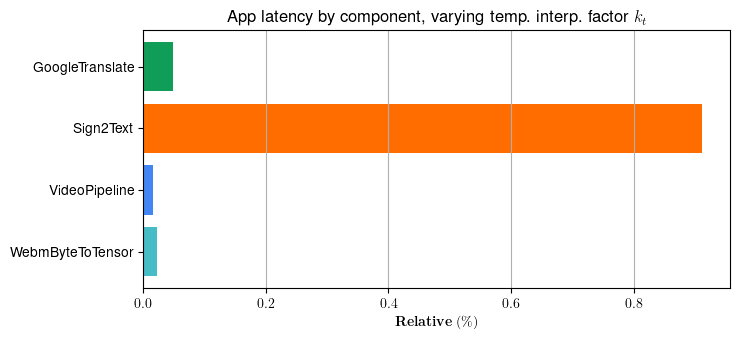

In [5]:
s2t_pipeline_times_percentage = np.array([s2t_pipeline_times[i,:] / x for i,x in enumerate(np.sum(s2t_pipeline_times,axis=1))])
s2t_pipeline_times_percentage_mean = np.mean(s2t_pipeline_times_percentage, axis=0)

plots = [plt.barh(["WebmByteToTensor", "VideoPipeline", "Sign2Text", "GoogleTranslate"], s2t_pipeline_times_percentage_mean, color=color_map)]

plt.grid(axis="x")
plt.xlabel("$\mathbf{Relative~(\%)}$")
# plt.xticks([x*0.1 for x in range(10+1)])
# plt.xticks([x*0.1 for x in range(10+1)])

plt.title("App latency by component, varying temp. interp. factor $k_t$")
plt.show()
# plt.savefig("waterfall_diagram_v3.png")

### Above is not a very good plot, probably better as just a table: 

In [8]:
table = df(np.round(s2t_pipeline_times_percentage,4) * 100, columns=components)
df_ltx = table.to_latex()
table

,WebmByteToTensor,VideoPipeline,Sign2Text,GoogleTranslate
0,1.85,0.99,93.19,3.98
1,2.42,2.09,90.28,5.21
2,2.64,1.84,89.86,5.67


In [7]:
print(df_ltx.replace("0"*4, r"\%"))

\begin{tabular}{lrrrr}
\toprule
 & WebmByteToTensor & VideoPipeline & Sign2Text & GoogleTranslate \\
\midrule
0 & 1.85\% & 0.99\% & 93.19\% & 3.98\% \\
1 & 2.42\% & 2.09\% & 90.28\% & 5.21\% \\
2 & 2.64\% & 1.84\% & 89.86\% & 5.67\% \\
\bottomrule
\end{tabular}



# Performance test [Speech2Text]

In [9]:
stt_model = SpeechToText()

In [ ]:
num_vids = 32
speech_videos = [f"./experiment-data/experiment_speech_vids/speech{i}.webm" for i in range(1,num_vids+1)]

speech_video_lens = {}
for x in speech_videos:
    data = read_webm_bytes_from_file(x)
    speech_video_lens[x] = webm_bytes_to_tensor(data).shape[0]

# speech_video_lens

In [29]:
""" Takes in a list of videos and monitors performance on the full STT pipeline """
def test_suite_stt(videos, repetitions=1, stt_model=None):
    assert stt_model is not None, "Missing Speech2Text model."
    test_suite_ID = uuid.uuid4()
    for rep in range(repetitions):
        print(f"{red}Test Suite [{test_suite_ID}] {ylw}@ {grn}ITER {rep+1}{blk}")
        for video_idx in videos:
            repetition_ID = uuid.uuid4()

            # ? get webm bytes [with audio track], just like we receive via websocket
            data = read_webm_bytes_from_file(video_idx)
            fps = 30.
            length_in_seconds = speech_video_lens[video_idx] / fps

            waveform = monitor_perf(webm_to_waveform, 
                                 data, 
                                 test_suite_ID=test_suite_ID, 
                                 repetition_ID=repetition_ID, 
                                 _input=(type(data), len(data)))

            # y = stt_model(waveform, self.spoken_language)
            y = monitor_perf(stt_model.inference, waveform, 
                             "US", # language_from
                             variation    ="Speech2Text", 
                             _input       =str(length_in_seconds)+" s", # num video frames
                             test_suite_ID=test_suite_ID, 
                             repetition_ID=repetition_ID)[0]

            lang_from, lang_to = "DE", "US"
            monitor_perf(GoogleTranslator(source=google_languages[lang_from], target=google_languages[lang_to]).translate, y, 
                         variation="Google Translate", 
                         test_suite_ID=test_suite_ID, 
                         repetition_ID=repetition_ID)
        LOG.perfmon_step()
    print(f"{red}Test Suite [{test_suite_ID}] {ylw}@ {grn}FINISHED{blk}")


In [ ]:
# LOG.reset_perf_metrics()
test_suite_stt(speech_videos, repetitions=2, stt_model=stt_model)

In [33]:
LOG.perf_metrics

,Function Name,Variation,Input Dims,time,perf_counter,process_time,Test Suite ID,Repetition ID
0,webm_to_waveform,None,"(<class 'bytes'>, 1104047)",0.052310,0.052309,0.013738,9af11656-bd76-4dd5-9038-4388712163e8,64943ebb-ed16-4830-b45e-c74c01bb49b8
1,inference,Speech2Text,3.533333333333333 s,1.313449,1.313453,3.255743,9af11656-bd76-4dd5-9038-4388712163e8,64943ebb-ed16-4830-b45e-c74c01bb49b8
2,translate,Google Translate,None,0.000011,0.000011,0.000010,9af11656-bd76-4dd5-9038-4388712163e8,64943ebb-ed16-4830-b45e-c74c01bb49b8
3,webm_to_waveform,None,"(<class 'bytes'>, 2915121)",0.060669,0.060669,0.023856,9af11656-bd76-4dd5-9038-4388712163e8,99bf1228-4176-4029-9e63-82430756e0b2
4,inference,Speech2Text,9.166666666666666 s,2.434162,2.434169,5.721832,9af11656-bd76-4dd5-9038-4388712163e8,99bf1228-4176-4029-9e63-82430756e0b2
...,...,...,...,...,...,...,...,...
283,inference,Speech2Text,20.4 s,3.773283,3.773294,8.941814,9af11656-bd76-4dd5-9038-4388712163e8,2f9beb98-45de-4655-a0d1-18d4c32f89b1
284,translate,Google Translate,None,0.000010,0.000010,0.000010,9af11656-bd76-4dd5-9038-4388712163e8,2f9beb98-45de-4655-a0d1-18d4c32f89b1
285,webm_to_waveform,None,"(<class 'bytes'>, 4106119)",0.068080,0.068082,0.028439,9af11656-bd76-4dd5-9038-4388712163e8,ad75b5f8-cbb9-4f8a-b414-3029ecd22c13
286,inference,Speech2Text,12.833333333333334 s,3.044107,3.044116,7.433785,9af11656-bd76-4dd5-9038-4388712163e8,ad75b5f8-cbb9-4f8a-b414-3029ecd22c13


In [34]:
LOG.save_perf_metrics()